# Clustering Musical Venues Ward Level

## 1. Research Question

What factors impact the number of music venues in London and how can it be quantified?

## 2. Setting Up Libraries

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import re
import os

import statsmodels.formula.api as smf
from matplotlib.colors import ListedColormap

import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_samples, silhouette_score

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

## Set up Caching Function

In [2]:
import os
from requests import get
from urllib.parse import urlparse

def cache_data(src:str, dest:str) -> str:
    """Downloads and caches a remote file locally.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that we don't need to remember to
    do so ourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th time.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dest : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    # Check if dest+filename does *not* exist -- 
    # that would mean we have to download it!
    if not os.path.isfile(dfn) or os.path.getsize(dfn) < 1:
        
        print(f"{dfn} not found, downloading!")

        # Convert the path back into a list (without)
        # the filename -- we need to check that directories
        # exist first.
        path = os.path.split(dest)
        
        # Create any missing directories in dest(ination) path
        # -- os.path.join is the reverse of split 
        # but it doesn't work with lists... 
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        # Download and write the file
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print('Done downloading...')

    else:
        print(f"Found {dfn} locally!")

    return dfn

## 3. Load Data

### 3.1 London Ward Shapefile Data

Source of london ward shapefile data is from London Data Store: https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london

In [3]:
#open all columns
pd.set_option('display.max_columns', None)

In [4]:
borough = gpd.read_file('ESRI/London_Borough_Excluding_MHW.shp')
borough.head(3)

NAME   GSS_CODE  HECTARES  NONLD_AREA ONS_INNER SUB_2009  \
0  Kingston upon Thames  E09000021  3,726.12        0.00         F     None   
1               Croydon  E09000008  8,649.44        0.00         F     None   
2               Bromley  E09000006 15,013.49        0.00         F     None   

  SUB_2006                                           geometry  
0     None  POLYGON ((516401.600 160201.800, 516407.300 16...  
1     None  POLYGON ((535009.200 159504.700, 535005.500 15...  
2     None  POLYGON ((540373.600 157530.400, 540361.200 15...

In [5]:
borough.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   NAME        33 non-null     object  
 1   GSS_CODE    33 non-null     object  
 2   HECTARES    33 non-null     float64 
 3   NONLD_AREA  33 non-null     float64 
 4   ONS_INNER   33 non-null     object  
 5   SUB_2009    0 non-null      object  
 6   SUB_2006    0 non-null      object  
 7   geometry    33 non-null     geometry
dtypes: float64(2), geometry(1), object(5)
memory usage: 2.2+ KB


In [6]:
ward_shp = gpd.read_file('data/London-wards-2018/London-wards-2018_ESRI/London_Ward_CityMerged.shp')
ward_shp.head(3)

NAME   GSS_CODE              DISTRICT  LAGSSCODE  \
0       Chessington South  E05000405  Kingston upon Thames  E09000021   
1  Tolworth and Hook Rise  E05000414  Kingston upon Thames  E09000021   
2              Berrylands  E05000401  Kingston upon Thames  E09000021   

   HECTARES  NONLD_AREA                                           geometry  
0    755.17        0.00  POLYGON ((516401.596 160201.802, 516407.302 16...  
1    259.46        0.00  POLYGON ((519552.998 164295.600, 519508.096 16...  
2    145.39        0.00  POLYGON ((518107.499 167303.399, 518114.301 16...

In [7]:
ward_shp.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 633 entries, 0 to 632
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   NAME        633 non-null    object  
 1   GSS_CODE    633 non-null    object  
 2   DISTRICT    633 non-null    object  
 3   LAGSSCODE   633 non-null    object  
 4   HECTARES    633 non-null    float64 
 5   NONLD_AREA  633 non-null    float64 
 6   geometry    633 non-null    geometry
dtypes: float64(2), geometry(1), object(4)
memory usage: 34.7+ KB


In [8]:
ward_shp.describe()

HECTARES  NONLD_AREA
count    633.00      633.00
mean     251.93        3.35
std      257.13       15.12
min       38.66        0.00
25%      119.59        0.00
50%      184.53        0.00
75%      290.79        0.00
max    2,903.96      154.28

<AxesSubplot:>

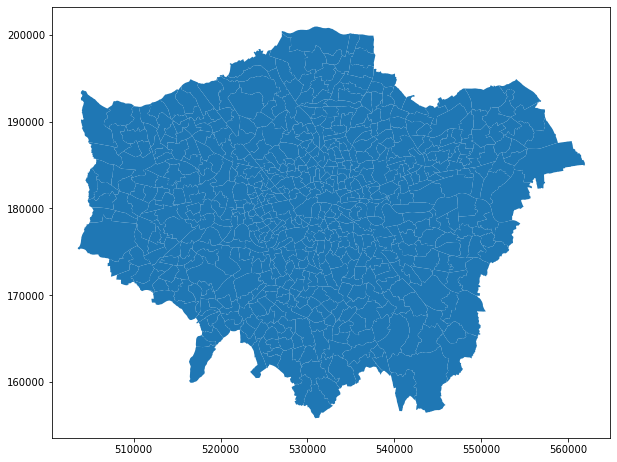

In [9]:
# Check the data
ward_shp.plot(figsize=(10,8))

### 3.2 Music venues by London Borough/Ward

Source from London Data Store: https://data.london.gov.uk/download/cultural-infrastructure-map/ceb42f72-aee0-4bdc-8eb8-973c66ec9f81/Music_venues_all.csv

In [10]:
cultural_venues = pd.read_csv('Music_venues_all.csv')
cultural_venues.head(3)

name         borough_name  \
0              Moth Club              HACKNEY   
1  Her Majesty's Theatre  CITY OF WESTMINSTER   
2         King's College  CITY OF WESTMINSTER   

                                             website  os_addressbase_uprn  \
0                                 www.mothclub.co.uk   100,023,022,302.00   
1  www.reallyusefultheatres.co.uk/our-theatres/he...   100,023,349,365.00   
2                                                NaN   100,022,807,697.00   

  borough_code ward_2018_name ward_2018_code  \
0    E09000012       Homerton      E05009376   
1    E09000033    St. James's      E05000644   
2    E09000033    St. James's      E05000644   

                             address1 address2 address3    easting   northing  \
0  Hackney Trades Hall Valette Street  Hackney      NaN 535,006.00 184,765.00   
1       Haymarket City Of Westminster      NaN      NaN 529,733.00 180,453.00   
2          Strand City Of Westminster      NaN      NaN 530,818.00 180,869.00   

   longitude  latitude     runtime  
0      -0.05     51.55  11/27/2022  
1      -0.13     51.51  11/27/2022  
2      -0.11     51.51  11/27/2022

In [11]:
cultural_venues.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 797 entries, 0 to 796
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   name                 797 non-null    object 
 1   borough_name         783 non-null    object 
 2   website              555 non-null    object 
 3   os_addressbase_uprn  781 non-null    float64
 4   borough_code         781 non-null    object 
 5   ward_2018_name       781 non-null    object 
 6   ward_2018_code       781 non-null    object 
 7   address1             797 non-null    object 
 8   address2             675 non-null    object 
 9   address3             39 non-null     object 
 10  easting              797 non-null    float64
 11  northing             797 non-null    float64
 12  longitude            797 non-null    float64
 13  latitude             797 non-null    float64
 14  runtime              797 non-null    object 
dtypes: float64(5), object(10)
memory usage: 

### 3.3 Ward Atlas Data

Source from Ward Atlas Data: https://data.london.gov.uk/dataset/ward-profiles-and-atlas 

Variables:
- population density (persons per sq km, 2018)
- average income (mean household income, 2012)
- employment rate (Employment rate 16-64 years old, 2011)
- average gcse score (2014)

In [12]:
ward_atlas = pd.read_csv('data/warddata.csv', sep=';', decimal=',')
ward_atlas.head(3)

ward_code       ward_name  population_density  average_income  \
0  E09000001  City of London            2,546.90           99390   
1  E05000026           Abbey           12,038.50           38870   
2  E05000027          Alibon            7,357.10           37290   

   employment_rate  avg_gcse_score  economically_active  in_employment   eco  
0            79.63          354.50                78.80          95.47  4972  
1            60.35          317.66                68.20          85.51  6419  
2            63.11          307.45                67.50          87.83  4798

In [13]:
ward_atlas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625 entries, 0 to 624
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ward_code            625 non-null    object 
 1   ward_name            625 non-null    object 
 2   population_density   625 non-null    float64
 3   average_income       625 non-null    int64  
 4   employment_rate      625 non-null    float64
 5   avg_gcse_score       625 non-null    float64
 6   economically_active  625 non-null    float64
 7   in_employment        625 non-null    float64
 8   eco                  625 non-null    int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 44.1+ KB


In [14]:
url="https://data.london.gov.uk/download/ward-profiles-and-atlas/772d2d64-e8c6-46cb-86f9-e52b4c7851bc/ward-profiles-excel-version.csv"
ward2 = pd.read_csv(url, encoding= 'unicode_escape')
ward2.head(3)

Ward name Old code   New code  Population - 2015  \
0                 City of London     00AA  E09000001           8,100.00   
1   Barking and Dagenham - Abbey   00ABFX  E05000026          14,750.00   
2  Barking and Dagenham - Alibon   00ABFY  E05000027          10,600.00   

   Children aged 0-15 - 2015  Working-age (16-64) - 2015  \
0                     650.00                    6,250.00   
1                   3,850.00                   10,150.00   
2                   2,700.00                    6,800.00   

   Older people aged 65+ - 2015  % All Children aged 0-15 - 2015  \
0                      1,250.00                             8.00   
1                        750.00                            26.00   
2                      1,050.00                            25.70   

   % All Working-age (16-64) - 2015  % All Older people aged 65+ - 2015  \
0                             76.90                               15.20   
1                             69.00                                5.00   
2                             64.30                               10.00   

   Mean Age - 2013  Median Age - 2013  Area - Square Kilometres  \
0            41.30              39.00                      3.20   
1            29.50              29.00                      1.30   
2            33.80              33.00                      1.40   

   Population density (persons per sq km) - 2013  % BAME - 2011  \
0                                       2,538.10          21.40   
1                                      10,500.00          71.90   
2                                       7,428.60          29.90   

   % Not Born in UK - 2011  \
0                    36.70   
1                    57.30   
2                    24.70   

   % English is First Language of no one in household - 2011  \
0                                              11.90           
1                                              25.70           
2                                               7.90           

   General Fertility Rate - 2013  Male life expectancy -2009-13  \
0                          38.40                          84.30   
1                          97.60                          80.20   
2                          83.30                          77.20   

   Female life expectancy -2009-13   \
0                             88.60   
1                             83.90   
2                             80.60   

   % children in reception year who are obese - 2011/12 to 2013/14  \
0                                              11.10                 
1                                              13.30                 
2                                              10.00                 

   % children in year 6 who are obese- 2011/12 to 2013/14  \
0                                              23.20        
1                                              24.70        
2                                              26.00        

   Rate of All Ambulance Incidents per 1,000 population - 2014  \
0                                             140.00             
1                                             157.30             
2                                             139.80             

   Rates of ambulance call outs for alcohol related illness - 2014  \
0                                              19.30                 
1                                               1.30                 
2                                               0.90                 

   Number Killed or Seriously Injured on the roads - 2014  \
0                                              57.00        
1                                               2.00        
2                                               1.00        

   In employment (16-64) - 2011  Employment rate (16-64) - 2011  \
0                      4,555.00                           79.60   
1                      5,444.00                           60.30   
2                      4,143.00                

In [15]:
ward2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 67 columns):
 #   Column                                                                       Non-Null Count  Dtype  
---  ------                                                                       --------------  -----  
 0   Ward name                                                                    660 non-null    object 
 1   Old code                                                                     660 non-null    object 
 2   New code                                                                     660 non-null    object 
 3   Population - 2015                                                            660 non-null    float64
 4   Children aged 0-15 - 2015                                                    660 non-null    float64
 5   Working-age (16-64) - 2015                                                   660 non-null    float64
 6   Older people aged 65+ - 2015              

In [16]:
ward2.describe()

Population - 2015  Children aged 0-15 - 2015  \
count             660.00                     660.00   
mean          121,988.86                  23,510.23   
std         2,151,291.62                 407,710.55   
min             5,300.00                     650.00   
25%            11,700.00                   2,150.00   
50%            13,800.00                   2,700.00   
75%            16,062.50                   3,400.00   
max        54,613,400.00              10,335,450.00   

       Working-age (16-64) - 2015  Older people aged 65+ - 2015  \
count                      660.00                        660.00   
mean                    79,260.08                     19,219.09   
std                  1,363,510.05                    380,835.19   
min                      3,050.00                        600.00   
25%                      7,787.50                      1,200.00   
50%                      9,600.00                      1,500.00   
75%                     11,200.00                      1,900.00   
max                 34,540,350.00                  9,737,650.00   

       % All Children aged 0-15 - 2015  % All Working-age (16-64) - 2015  \
count                           660.00                            660.00   
mean                             19.79                             68.41   
std                               3.73                              5.06   
min                               6.50                             57.40   
25%                              17.70                             64.57   
50%                              19.80                             67.40   
75%                              22.02                             71.93   
max                              32.70                             83.90   

       % All Older people aged 65+ - 2015  Mean Age - 2013  Median Age - 2013  \
count                              660.00           660.00             660.00   
mean                                11.80            35.96              34.46   
std                                  4.21             3.04               3.90   
min                                  3.70            28.70              27.00   
25%                                  8.50            33.80              32.00   
50%                                 11.10            35.50              34.00   
75%                                 14.40            38.00              37.00   
max                                 24.30            44.30              46.00   

       Area - Square Kilometres  \
count                    660.00   
mean                     204.61   
std                    5,070.46   
min                        0.40   
25%                        1.30   
50%                        1.95   
75%                        3.20   
max                  130,259.70   

       Population density (persons per sq km) - 2013  % BAME - 2011  \
count                                         660.00         660.00   
mean                                        8,161.46          38.69   
std                                         4,819.13          18.70   
min                                           181.00           4.10   
25%                                         4,611.77          23.50   
50%                                         6,972.95          36.20   
75%                                        10,913.98          51.82   
max                                        29,750.00          93.70   

       % Not Born in UK - 2011  \
count                   660.00   
mean                     36.04   
std                      13.63   
min                       5.10   
25%                      26.90   
50%                      37.30   
75%                      45.52   
max                      68.50   

       % English is First Language of no one in household - 2011  \
count                                             660.00           
mean                                               12.84           
std                      

## 4. Data Wrangling / Preparation

### 4.1 Group Cultural Activities Data per Ward

In [17]:
groupby_cult = cultural_venues.groupby('ward_2018_code').name.agg(Count='count').reset_index()
#check output
groupby_cult.head()

ward_2018_code  Count
0      E05000026      2
1      E05000034      1
2      E05000037      1
3      E05000043      1
4      E05000046      1

In [18]:
groupby_cult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283 entries, 0 to 282
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ward_2018_code  283 non-null    object
 1   Count           283 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.5+ KB


### 4.2 Join Cultural Facilities Data with Ward Atlas Data

In [19]:
# Join groupby_cult with ward_atlas data

comb1 = groupby_cult.merge(ward_atlas, left_on='ward_2018_code', right_on='ward_code', how='left')
#check output
comb1.head(3)

ward_2018_code  Count  ward_code ward_name  population_density  \
0      E05000026      2  E05000026     Abbey           12,038.50   
1      E05000034      1  E05000034     Heath            5,550.00   
2      E05000037      1  E05000037  Parsloes            8,166.70   

   average_income  employment_rate  avg_gcse_score  economically_active  \
0       38,870.00            60.35          317.66                68.20   
1       36,080.00            61.43          297.33                67.40   
2       36,640.00            61.45          312.21                65.50   

   in_employment      eco  
0          85.51 6,419.00  
1          85.66 4,812.00  
2          87.25 4,401.00

In [20]:
#rearranging columns neatly
comb1 = comb1[['ward_code', 'ward_name', 'Count', 'population_density', 'average_income', 'employment_rate', 'avg_gcse_score']]

In [21]:
# rename columns
comb1.rename(
    columns={"Count": "music_venues"},
    inplace=True,
)
#check output
comb1.head(3)

ward_code ward_name  music_venues  population_density  average_income  \
0  E05000026     Abbey             2           12,038.50       38,870.00   
1  E05000034     Heath             1            5,550.00       36,080.00   
2  E05000037  Parsloes             1            8,166.70       36,640.00   

   employment_rate  avg_gcse_score  
0            60.35          317.66  
1            61.43          297.33  
2            61.45          312.21

In [22]:
comb1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283 entries, 0 to 282
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ward_code           200 non-null    object 
 1   ward_name           200 non-null    object 
 2   music_venues        283 non-null    int64  
 3   population_density  200 non-null    float64
 4   average_income      200 non-null    float64
 5   employment_rate     200 non-null    float64
 6   avg_gcse_score      200 non-null    float64
dtypes: float64(4), int64(1), object(2)
memory usage: 17.7+ KB


In [23]:
comb1.describe()

music_venues  population_density  average_income  employment_rate  \
count        283.00              200.00          200.00           200.00   
mean           2.76            9,005.98       54,975.00            70.56   
std            4.58            5,204.86       16,061.47             6.58   
min            1.00              529.60       33,120.00            46.11   
25%            1.00            5,171.50       44,825.00            67.26   
50%            1.00            7,935.70       52,385.00            71.48   
75%            3.00           12,144.25       61,255.00            75.10   
max           42.00           30,125.00      176,950.00            83.90   

       avg_gcse_score  
count          200.00  
mean           329.07  
std             22.47  
min            286.69  
25%            312.41  
50%            324.86  
75%            343.14  
max            396.21

### 4.3 Data Preparation for Multiple Regression

In [24]:
#copy comb1 data into df_reg
df_reg = comb1.copy()

In [25]:
# add columns of ln income and ln house prices
df_reg['ln_population_density'] = np.log(df_reg['population_density'])
df_reg['ln_average_income'] = np.log(df_reg['average_income'])


#drop average income and house prices columns
df_reg.drop(columns=['population_density', 'average_income'], inplace=True)

#check output 
df_reg.head(3)

ward_code ward_name  music_venues  employment_rate  avg_gcse_score  \
0  E05000026     Abbey             2            60.35          317.66   
1  E05000034     Heath             1            61.43          297.33   
2  E05000037  Parsloes             1            61.45          312.21   

   ln_population_density  ln_average_income  
0                   9.40              10.57  
1                   8.62              10.49  
2                   9.01              10.51

In [26]:
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283 entries, 0 to 282
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ward_code              200 non-null    object 
 1   ward_name              200 non-null    object 
 2   music_venues           283 non-null    int64  
 3   employment_rate        200 non-null    float64
 4   avg_gcse_score         200 non-null    float64
 5   ln_population_density  200 non-null    float64
 6   ln_average_income      200 non-null    float64
dtypes: float64(4), int64(1), object(2)
memory usage: 17.7+ KB


In [27]:
# Drop NaN values
df_reg = df_reg.dropna()
print(df_reg)

     ward_code       ward_name  music_venues  employment_rate  avg_gcse_score  \
0    E05000026           Abbey             2            60.35          317.66   
1    E05000034           Heath             1            61.43          297.33   
2    E05000037        Parsloes             1            61.45          312.21   
3    E05000043  Brunswick Park             1            71.39          339.34   
4    E05000046       Colindale             1            61.92          307.73   
..         ...             ...           ...              ...             ...   
195  E05000643   Regent's Park             1            62.44          296.62   
196  E05000644     St. James's            39            67.69          352.84   
197  E05000645       Tachbrook             2            75.19          368.00   
198  E05000647         Warwick             1            73.77          310.16   
199  E05000649        West End            42            71.34          363.13   

     ln_population_density 

### 4.4 Data Preparation for Clustering

In [28]:
#this dataset is standardised, based off comb1
df_cluster = comb1.copy()

In [29]:
# standardise cluster_df
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()

columns = ['music_venues', 'population_density', 'average_income', 'employment_rate', 'avg_gcse_score']

df_cluster[columns] = mms.fit_transform(df_cluster[columns])
#.values.reshape(-1,1)

#check output
df_cluster.head(3)

ward_code ward_name  music_venues  population_density  average_income  \
0  E05000026     Abbey          0.02                0.39            0.04   
1  E05000034     Heath          0.00                0.17            0.02   
2  E05000037  Parsloes          0.00                0.26            0.02   

   employment_rate  avg_gcse_score  
0             0.38            0.28  
1             0.41            0.10  
2             0.41            0.23

In [30]:
df_cluster.drop(['ward_name'], axis=1, inplace=True)

In [31]:
df_cluster.set_index('ward_code', inplace=True)
df_cluster.head(3)

music_venues  population_density  average_income  employment_rate  \
ward_code                                                                      
E05000026          0.02                0.39            0.04             0.38   
E05000034          0.00                0.17            0.02             0.41   
E05000037          0.00                0.26            0.02             0.41   

           avg_gcse_score  
ward_code                  
E05000026            0.28  
E05000034            0.10  
E05000037            0.23

In [32]:
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
Index: 283 entries, E05000026 to nan
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   music_venues        283 non-null    float64
 1   population_density  200 non-null    float64
 2   average_income      200 non-null    float64
 3   employment_rate     200 non-null    float64
 4   avg_gcse_score      200 non-null    float64
dtypes: float64(5)
memory usage: 13.3+ KB


In [33]:
# Drop NaN values
df_cluster = df_cluster.dropna()
print(df_cluster)

           music_venues  population_density  average_income  employment_rate  \
ward_code                                                                      
E05000026          0.02                0.39            0.04             0.38   
E05000034          0.00                0.17            0.02             0.41   
E05000037          0.00                0.26            0.02             0.41   
E05000043          0.00                0.16            0.14             0.67   
E05000046          0.00                0.40            0.05             0.42   
...                 ...                 ...             ...              ...   
E05000643          0.00                0.17            0.32             0.43   
E05000644          0.93                0.10            0.40             0.57   
E05000645          0.02                0.71            0.33             0.77   
E05000647          0.00                0.54            0.37             0.73   
E05000649          1.00                0

## 5. Analysis

### 5.1 Multiple Linear Regression between various independent variables against dependent variable of cultural_facilities

#### 5.1.1 Check the correlation between variables

In [34]:
#correlation coefficients between variables
df_reg.corr()

music_venues  employment_rate  avg_gcse_score  \
music_venues                   1.00            -0.08            0.09   
employment_rate               -0.08             1.00            0.43   
avg_gcse_score                 0.09             0.43            1.00   
ln_population_density          0.07            -0.21           -0.25   
ln_average_income              0.26             0.42            0.56   

                       ln_population_density  ln_average_income  
music_venues                            0.07               0.26  
employment_rate                        -0.21               0.42  
avg_gcse_score                         -0.25               0.56  
ln_population_density                   1.00               0.01  
ln_average_income                       0.01               1.00

In [35]:
#creating df for correlation, mainly dropping msoa code and name from df_reg
df_corr = df_reg.copy(deep=True)
df_corr = df_corr.drop(columns=['ward_code', 'ward_name'])
df_corr.head(3)

music_venues  employment_rate  avg_gcse_score  ln_population_density  \
0             2            60.35          317.66                   9.40   
1             1            61.43          297.33                   8.62   
2             1            61.45          312.21                   9.01   

   ln_average_income  
0              10.57  
1              10.49  
2              10.51

Text(0.5, 1.0, 'Correlation Matrix')

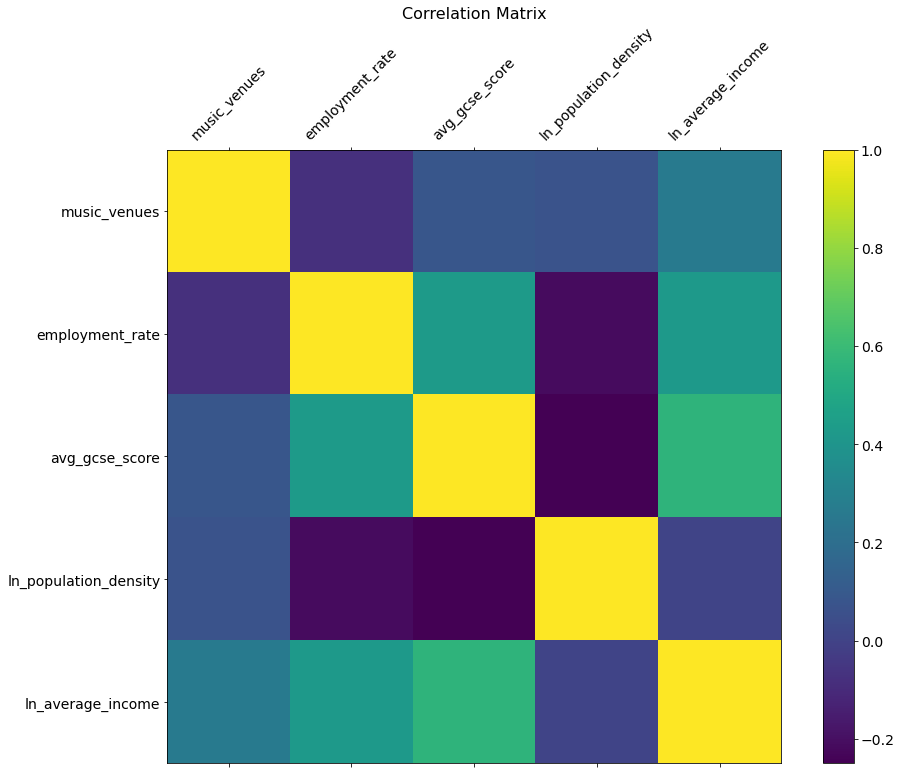

In [36]:
# Correlation Matrix
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(15, 11))
plt.matshow(df_reg.corr(), fignum=f.number)
plt.xticks(range(df_corr.shape[1]), df_corr.columns, fontsize=14, rotation=45)
plt.yticks(range(df_corr.shape[1]), df_corr.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

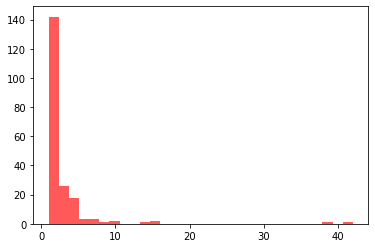

In [37]:
# Check distribution plot

# plotting histogram
plt.hist(df_reg['music_venues'],bins = 30,
         alpha = 0.65, color = 'red')
plt.show()

#### 5.1.2 Scatter Plot

<AxesSubplot:xlabel='ln_average_income', ylabel='employment_rate'>

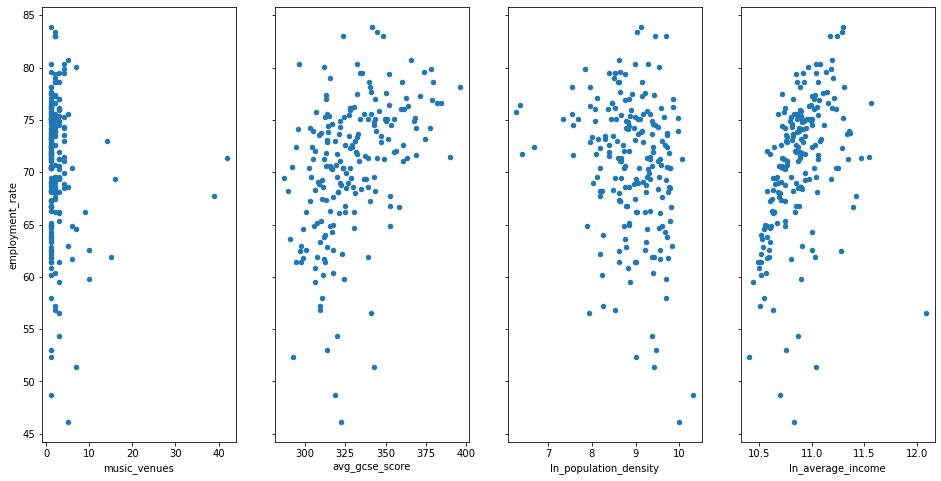

In [38]:
fig, axs = plt.subplots(1, 4, sharey=True)
df_reg.plot(kind='scatter', x='music_venues', y='employment_rate', ax=axs[0], figsize=(16, 8))
df_reg.plot(kind='scatter', x='avg_gcse_score', y='employment_rate', ax=axs[1] )
df_reg.plot(kind='scatter', x='ln_population_density', y='employment_rate', ax=axs[2])
df_reg.plot(kind='scatter', x='ln_average_income', y='employment_rate', ax=axs[3])

#### 5.1.3 Calculate VIF

In [39]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def compute_vif(considered_features):
    
    X = df_reg[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
        
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

compute_vif(['music_venues', 'avg_gcse_score', 'ln_population_density', 'ln_average_income'])

/tmp/ipykernel_31473/4049651137.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Variable  VIF
0           music_venues 1.08
1         avg_gcse_score 1.62
2  ln_population_density 1.11
3      ln_average_income 1.61

#### 5.1.4 Multiple Regression
We run a multiple linear regression of cultural facilities against employment rate, average GCSE score, population density, and average income.  

In [40]:
model_eco = smf.ols('employment_rate ~ music_venues', 
                        df_reg).fit()
model_eco.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        employment_rate   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.131
Date:                Sat, 26 Aug 2023   Prob (F-statistic):              0.289
Time:                        16:16:52   Log-Likelihood:                -659.53
No. Observations:                 200   AIC:                             1323.
Df Residuals:                     198   BIC:                             1330.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       70.8583      0.541    130.861      0.000      69.790      71.926
music_venues    -0.1117      0.105     -1.064      0.289      -0.319       0.095
==============================================================================
Omnibus:                       27.089   Durbin-Watson:                   1.457
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.148
Skew:                          -0.868   Prob(JB):                     2.33e-08
Kurtosis:                       4.098   Cond. No.                         6.06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
model_reg = smf.ols('employment_rate ~ music_venues + avg_gcse_score + ln_population_density + ln_average_income', 
                        df_reg).fit()
model_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        employment_rate   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     19.48
Date:                Sat, 26 Aug 2023   Prob (F-statistic):           1.69e-13
Time:                        16:16:52   Log-Likelihood:                -626.48
No. Observations:                 200   AIC:                             1263.
Df Residuals:                     195   BIC:                             1279.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               -37.5771     19.233     -1.954      0.052     -75.508       0.353
music_venues             -0.2588      0.093     -2.773      0.006      -0.443      -0.075
avg_gcse_score            0.0630      0.023      2.794      0.006       0.019       0.107
ln_population_density    -1.4241      0.608     -2.343      0.020      -2.623      -0.225
ln_average_income         9.2632      2.039      4.542      0.000       5.241      13.285
==============================================================================
Omnibus:                       65.021   Durbin-Watson:                   1.168
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              194.039
Skew:                          -1.350   Prob(JB):                     7.33e-43
Kurtosis:                       6.999   Cond. No.                     1.61e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.61e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 5.2 Clustering

K-Means eucledian distance, sensitive with outliers, formula use quadrat square. We use a standardised dataset for clustering. 

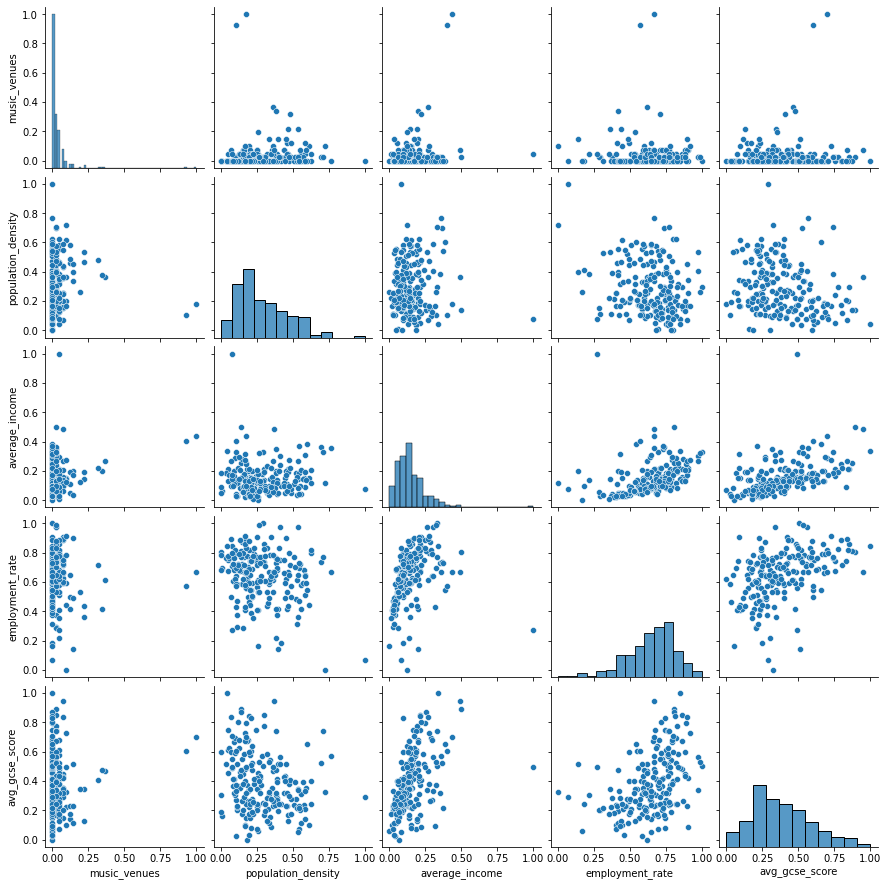

In [42]:
#check distribution plot for standardised dataset
sns.pairplot(df_cluster)

In [43]:
from sklearn.cluster import KMeans

In [44]:
# How many cluster - Using Silhouette 
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

In [45]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_cluster)
    score = silhouette_score(df_cluster, kmeans.labels_)
    silhouette_coefficients.append(score)

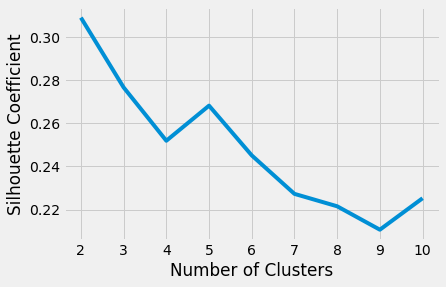

In [46]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [47]:
#Elbow method
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_cluster)
    sse.append(kmeans.inertia_)

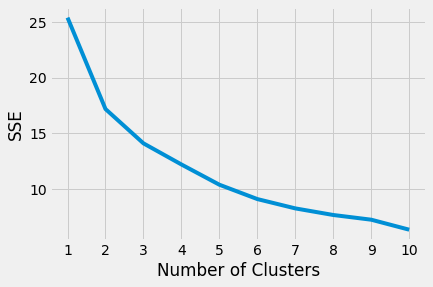

In [48]:
 plt.style.use("fivethirtyeight")
 plt.plot(range(1, 11), sse)
 plt.xticks(range(1, 11))
 plt.xlabel("Number of Clusters")
 plt.ylabel("SSE")
 plt.show()

In [49]:
from kneed import KneeLocator
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)

kl.elbow

3

In [50]:
kmeans = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=42
)

In [51]:
kmeans.fit(df_cluster)

KMeans(init='random', n_clusters=3, random_state=42)

In [52]:
kmeans.cluster_centers_

array([[0.020715  , 0.2236879 , 0.08204987, 0.56796661, 0.2328063 ],
       [0.04350692, 0.17878792, 0.20784861, 0.7593092 , 0.58834176],
       [0.0616659 , 0.52306108, 0.17018125, 0.59915349, 0.31805669]])

In [53]:
kmeans.labels_

array([0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 2, 2, 2, 1, 2, 0, 2, 2, 2, 0, 0, 2, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 2, 2,
       2, 2, 2, 2, 2, 1, 2, 1, 2, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 1, 1, 0, 1, 1, 1, 0, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2, 1, 2, 0, 0,
       2, 2, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 2, 2, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 2, 0, 1, 0, 0, 0, 2,
       0, 0, 0, 0, 1, 2, 2, 1, 0, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 0, 1, 2,
       2, 1], dtype=int32)

In [54]:
df_cluster['cluster'] = pd.Series(kmeans.labels_, index=df_cluster.index)

In [55]:
df_cluster['cluster'] = df_cluster['cluster'] + 1

In [56]:
#check output
df_cluster.head(10)

music_venues  population_density  average_income  employment_rate  \
ward_code                                                                      
E05000026          0.02                0.39            0.04             0.38   
E05000034          0.00                0.17            0.02             0.41   
E05000037          0.00                0.26            0.02             0.41   
E05000043          0.00                0.16            0.14             0.67   
E05000046          0.00                0.40            0.05             0.42   
E05000048          0.00                0.13            0.14             0.67   
E05000049          0.05                0.20            0.16             0.76   
E05000050          0.00                0.09            0.13             0.60   
E05000051          0.00                0.19            0.20             0.70   
E05000055          0.00                0.21            0.13             0.55   

           avg_gcse_score  cluster  
ward_code                           
E05000026            0.28        1  
E05000034            0.10        1  
E05000037            0.23        1  
E05000043            0.48        2  
E05000046            0.19        1  
E05000048            0.46        2  
E05000049            0.58        2  
E05000050            0.37        1  
E05000051            0.68        2  
E05000055            0.60        2

In [57]:
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, E05000026 to E05000649
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   music_venues        200 non-null    float64
 1   population_density  200 non-null    float64
 2   average_income      200 non-null    float64
 3   employment_rate     200 non-null    float64
 4   avg_gcse_score      200 non-null    float64
 5   cluster             200 non-null    int32  
dtypes: float64(5), int32(1)
memory usage: 10.2+ KB


In [58]:
# Joining with shp file

cluster_shp = pd.merge(ward_shp, df_cluster, left_on='GSS_CODE', right_on='ward_code', how='left')
cluster_shp.head(3)

NAME   GSS_CODE              DISTRICT  LAGSSCODE  \
0       Chessington South  E05000405  Kingston upon Thames  E09000021   
1  Tolworth and Hook Rise  E05000414  Kingston upon Thames  E09000021   
2              Berrylands  E05000401  Kingston upon Thames  E09000021   

   HECTARES  NONLD_AREA                                           geometry  \
0    755.17        0.00  POLYGON ((516401.596 160201.802, 516407.302 16...   
1    259.46        0.00  POLYGON ((519552.998 164295.600, 519508.096 16...   
2    145.39        0.00  POLYGON ((518107.499 167303.399, 518114.301 16...   

   music_venues  population_density  average_income  employment_rate  \
0           NaN                 NaN             NaN              NaN   
1           NaN                 NaN             NaN              NaN   
2          0.00                0.21            0.15             0.76   

   avg_gcse_score  cluster  
0             NaN      NaN  
1             NaN      NaN  
2            0.51     2.00

In [59]:
#check datatype
cluster_shp.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 633 entries, 0 to 632
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   NAME                633 non-null    object  
 1   GSS_CODE            633 non-null    object  
 2   DISTRICT            633 non-null    object  
 3   LAGSSCODE           633 non-null    object  
 4   HECTARES            633 non-null    float64 
 5   NONLD_AREA          633 non-null    float64 
 6   geometry            633 non-null    geometry
 7   music_venues        200 non-null    float64 
 8   population_density  200 non-null    float64 
 9   average_income      200 non-null    float64 
 10  employment_rate     200 non-null    float64 
 11  avg_gcse_score      200 non-null    float64 
 12  cluster             200 non-null    float64 
dtypes: float64(8), geometry(1), object(4)
memory usage: 69.2+ KB


In [60]:
cluster_shp['cluster'] = cluster_shp['cluster'].astype(str)

In [61]:
cluster_shp.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 633 entries, 0 to 632
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   NAME                633 non-null    object  
 1   GSS_CODE            633 non-null    object  
 2   DISTRICT            633 non-null    object  
 3   LAGSSCODE           633 non-null    object  
 4   HECTARES            633 non-null    float64 
 5   NONLD_AREA          633 non-null    float64 
 6   geometry            633 non-null    geometry
 7   music_venues        200 non-null    float64 
 8   population_density  200 non-null    float64 
 9   average_income      200 non-null    float64 
 10  employment_rate     200 non-null    float64 
 11  avg_gcse_score      200 non-null    float64 
 12  cluster             633 non-null    object  
dtypes: float64(7), geometry(1), object(5)
memory usage: 69.2+ KB


<AxesSubplot:>

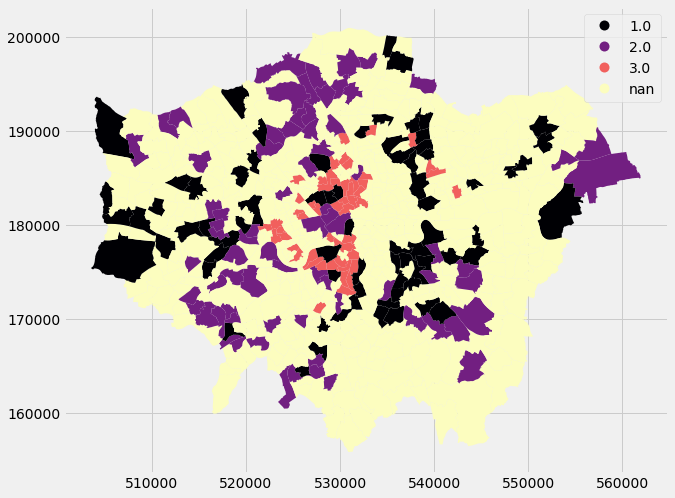

In [62]:
# Plotting
cluster_shp.plot(column='cluster', cmap='magma', edgecolor='none', legend=True, figsize=(12,8))

In [63]:
df_cluster.groupby("cluster").mean()

music_venues  population_density  average_income  employment_rate  \
cluster                                                                      
1                0.02                0.22            0.08             0.57   
2                0.04                0.18            0.21             0.76   
3                0.06                0.52            0.17             0.60   

         avg_gcse_score  
cluster                  
1                  0.23  
2                  0.59  
3                  0.32